In [1]:
import torch
from braindecode.models import ShallowFBCSPNet
from braindecode.util import set_random_seeds
from braindecode.datasets import MOABBDataset
from numpy import multiply
from braindecode.preprocessing import (
    Preprocessor, 
    exponential_moving_standardize,
    preprocess,
    create_windows_from_events,
)
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from braindecode import EEGClassifier

In [2]:
subject_id = 3
dataset = MOABBDataset(dataset_name="BNCI2014_001", subject_ids=[subject_id])

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/moabb/datasets/download.py:55: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BNCI_PATH"
  set_config(key, get_config("MNE_DATA"))


MNE_DATA is not already configured. It will be set to default location in the home directory - /Users/ingerlisamalia/mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location


/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
100%|█████████████████████████████████████| 44.1M/44.1M [00:00<00:00, 32.3GB/s]
SHA256 hash of downloaded file: 7e731ee8b681d5da6ecb11ae1d4e64b1653c7f15aad5d6b7620b25ce53141e80
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lampx.tugraz.at'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
100%|████████

In [3]:
# Preprocessing
low_cut_hz = 4.0 # low cut frequency for filtering
high_cut_hz = 38.0 # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000
# Factor to convert from V to uV
factor = 1e6

preprocessors = [
    Preprocessor("pick_types", eeg=True, meg=False, stim=False), # keep EEG sensors
    Preprocessor(lambda data: multiply(data, factor)), # convert from V to uV
    Preprocessor(
        exponential_moving_standardize,
        factor_new = factor_new,
        init_block_size = init_block_size,
    ),
]

# Transform the data
preprocess(dataset, preprocessors, n_jobs=-1)

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [4]:
# Extract compute windows
trial_start_offset_seconds = -0.5
# extract sampling frequency, check that they are the same in all datasets
sfreq = dataset.datasets[0].raw.info["sfreq"]
assert all([ds.raw.info["sfreq"] == sfreq for ds in dataset.datasets])
# calculate the trial start offset in samples
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# create windows using braindecode function, needs parameters to define how trials should be used
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples = trial_start_offset_samples,
    trial_stop_offset_samples = 0,
    preload = True,
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']


In [5]:
splitted = windows_dataset.split("session")
train_set = splitted["0train"]
valid_set = splitted["1test"]

In [6]:
cuda = torch.cuda.is_available()
device = "cuda" if cuda else "cpu"
if cuda:
    torch.backends.cudnn.benchmark = True
# set random seed to roughly reproduce results
# with cudnn benmarck = true, less consistent results
# cudnn benchmark = false, more consistent but increased computation time
seed = 2025
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
classes = list(range(n_classes))
# extract number of chans and time steps from dataset
n_chans = train_set[0][0].shape[0]
n_times = train_set[0][0].shape[1]

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    n_times = n_times, 
    final_conv_length = "auto",
)

# display torchinfo table describing the model
print(model)

# send model to GPU
if cuda: 
    model = model.cuda()

Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 22, 1125]             [1, 4]                    --                        --
├─Ensure4d (ensuredims): 1-1             [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
├─Rearrange (dimshuffle): 1-2            [1, 22, 1125, 1]          [1, 1, 1125, 22]          --                        --
├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1125, 22]          [1, 40, 1101, 1]          36,240                    --
├─BatchNorm2d (bnorm): 1-4               [1, 40, 1101, 1]          [1, 40, 1101, 1]          80                        --
├─Expression (conv_nonlin_exp): 1-5      [1, 40, 1101, 1]          [1, 40, 1101, 1]          --                        --
├─AvgPool2d (pool): 1-6                  [1, 40, 1101, 1]          [1, 40, 69, 1]            --                        [75, 1]
├─Express

/Users/ingerlisamalia/miniconda3/lib/python3.12/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [13]:
lr = 0.0625 * 0.01
weight_decay = 0

batch_size = 128
n_epochs = 15

clf = EEGClassifier(
    model,
    criterion = torch.nn.CrossEntropyLoss,
    optimizer = torch.optim.AdamW,
    train_split = predefined_split(valid_set),
    optimizer__lr = lr,
    optimizer__weight_decay = weight_decay,
    batch_size = batch_size,
    callbacks = [
        "accuracy",
        ("lr_scheduler", LRScheduler("CosineAnnealingLR", T_max = n_epochs - 1)),
    ],
    device = device,
    classes = classes,
)

_ = clf.fit(train_set, y = None, epochs = n_epochs)

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.9965        0.0448       0.7049            0.7049        0.8224  0.0006  2.3937
      2            1.0000        0.0543       0.7604            0.7604        0.6687  0.0006  1.7173
      3            1.0000        0.0311       0.7535            0.7535        0.6889  0.0006  1.8807
      4            1.0000        0.0367       0.7674            0.7674        0.6292  0.0006  1.6822
      5            1.0000        0.0449       0.7431            0.7431        0.6518  0.0005  1.6889
      6            1.0000        0.0310       0.7292            0.7292        0.6835  0.0004  1.6787
      7            1.0000        0.0416       0.7326            0.7326        0.6692  0.0004  1.6981
      8            1.0000        0.0303       0.7465            0.7465        0.6257  0.000

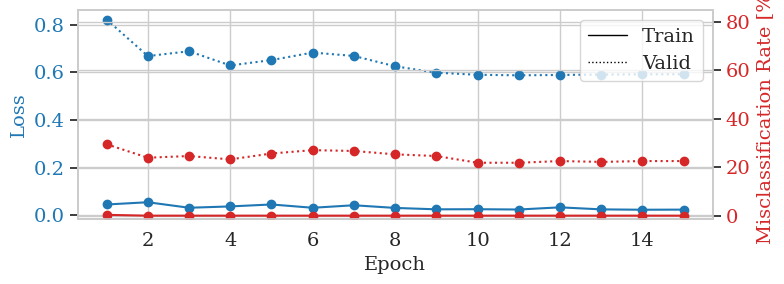

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
# Extract loss and accuracy values for plotting from history object
results_columns = ["train_loss", "valid_loss", "train_accuracy", "valid_accuracy"]
df = pd.DataFrame(
    clf.history[:, results_columns],
    columns=results_columns,
    index=clf.history[:, "epoch"],
)

# get percent of misclass for better visual comparison to loss
df = df.assign(
    train_misclass=100 - 100 * df.train_accuracy,
    valid_misclass=100 - 100 * df.valid_accuracy,
)

fig, ax1 = plt.subplots(figsize=(8, 3))
df.loc[:, ["train_loss", "valid_loss"]].plot(
    ax=ax1, style=["-", ":"], marker="o", color="tab:blue", legend=False, fontsize=14
)

ax1.tick_params(axis="y", labelcolor="tab:blue", labelsize=14)
ax1.set_ylabel("Loss", color="tab:blue", fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ["train_misclass", "valid_misclass"]].plot(
    ax=ax2, style=["-", ":"], marker="o", color="tab:red", legend=False
)
ax2.tick_params(axis="y", labelcolor="tab:red", labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color="tab:red", fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(
    Line2D([0], [0], color="black", linewidth=1, linestyle="-", label="Train")
)
handles.append(
    Line2D([0], [0], color="black", linewidth=1, linestyle=":", label="Valid")
)
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()